In [31]:
# !pip install qiskit
# !pip install qiskit_ibm_runtime
# !pip install matplotlib
# !pip install pylatexenc
# !pip install qiskit_aer

Grover problem : 

**Search** 
**Input:** A function $f : \Sigma^n \to \Sigma$
**Output:** A string $x \in \Sigma^n$ satisfying $f(x) = 1$, or "no solution" if no such string $x$ exists.

**Unique Search**
**Input:** A function of the form $f : \Sigma^n \to \Sigma$
**Promise:** There is exactly one string $z \in \Sigma^n$ for which $f(z) = 1$, with $f(x) = 0$ for all strings $x \neq z$.
**Output:** The string $z$.

We will assume that we have access to the function $f : \Sigma^n \to \Sigma$ through a query gate defined in the usual way, which is as
$$
U_f (|a\rangle |x\rangle) = |a \oplus f(x)\rangle |x\rangle
$$
for every $x \in \Sigma^n$ and $a \in \Sigma$. This is the action of $U_f$ on standard basis states, and its action in general is determined by linearity.





In [32]:
import math
from math import pi, asin, sqrt, floor
from qiskit import QuantumCircuit
# from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Session as Session
# from qiskit.primitives import StatevectorSampler as Sampler

# service = QiskitRuntimeService(channel="ibm_quantum",token="dd63143b2482be4578a9c8a3b57387eb937513750a212cc004f0cc09303cbf32f4a3702df59fee1b37d1f5338d6f15db61cf554c3d4f96d44cfb9845ff5560f0")
# backend = service.least_busy(operational=True, simulator=False)

# backend.name

**Marking Grover Oracle  using the Phase Query Gate Zf**

Grover's algorithm makes use of operations known as phase query gates. In contrast to an ordinary query gate $U_f$, defined for a given function $f$ in the usual way described above, a phase query gate for the function $f$ is defined as
$$
Z_f |x\rangle = (-1)^{f(x)} |x\rangle
$$
for every string $x \in \Sigma^n$.
The operation $Z_f$ can be implemented using one query gate $U_f$ as this diagram suggests:
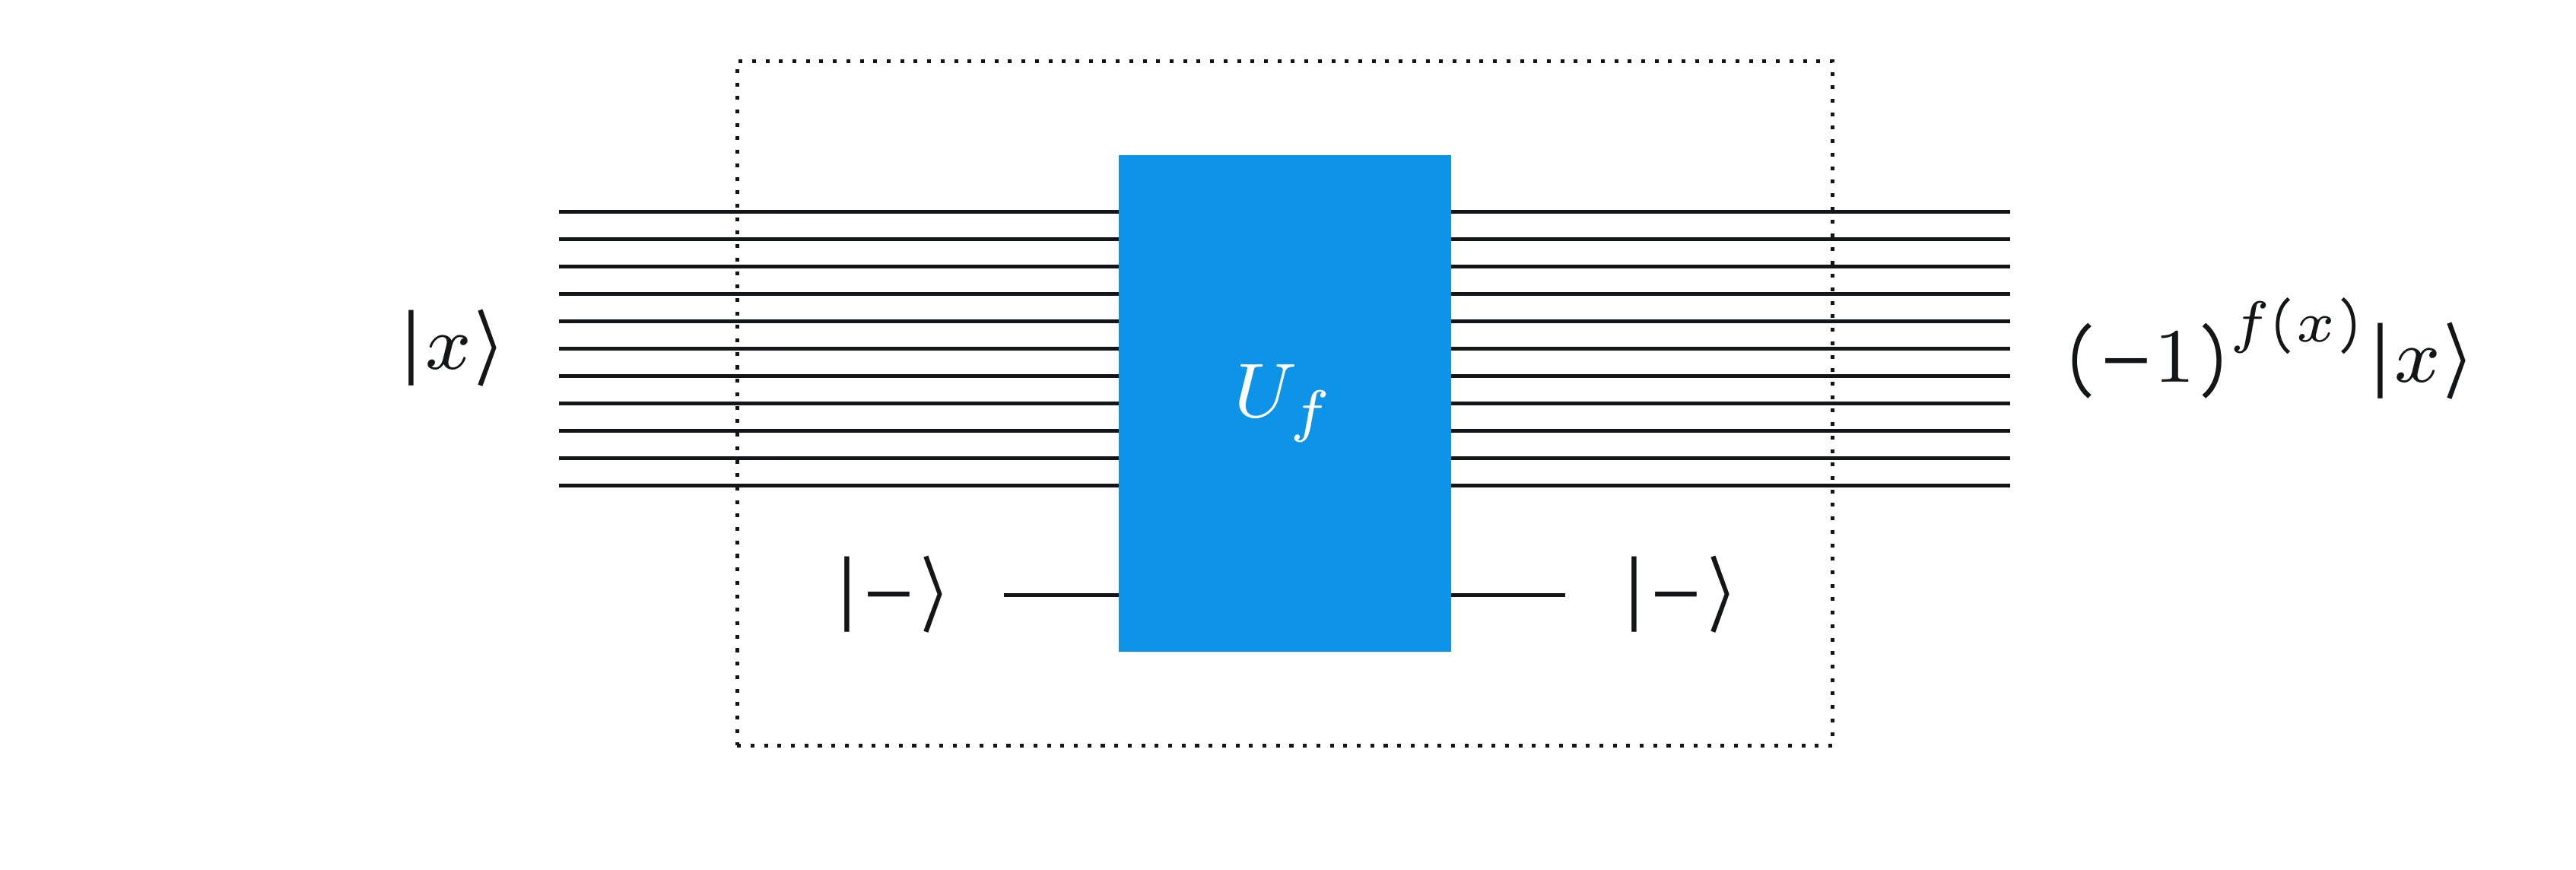


In [33]:
def grover_oracle(marked_states): # implementing Zf Phase query gate
    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0]) #if there are n bits so qc with n qubits and so on

    qc = QuantumCircuit(num_qubits)



    for target in marked_states:
        rev_target = target[::-1] # rev as qiskit uses little endiane

        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)] # finding starting qubit 0


        qc.x(zero_inds)

        qc.barrier(range(num_qubits))
        #Multi control CCZ gate
        qc.h(num_qubits - 1)
        qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
        qc.h(num_qubits - 1)

        qc.barrier(range(num_qubits))

        qc.x(zero_inds)
    return qc

**Phase Query Gate for the n-bit OR Function**

In addition to the operation $Z_f$, we will also make use of a phase query gate for the $n$-bit OR function, which is defined as follows for each string $x \in \Sigma^n$:

$$
\text{OR}(x) =
\begin{cases}
0 & \text{if } x = 0_n \\
1 & \text{if } x \neq 0_n
\end{cases}
$$

Explicitly, the phase query gate for the $n$-bit OR function operates like this:

$$
Z_{\text{OR}} |x\rangle =
\begin{cases}
|x\rangle & \text{if } x = 0_n \\
-|x\rangle & \text{if } x \neq 0_n
\end{cases}
$$

To be clear, this is how $Z_{\text{OR}}$ operates on standard basis states; its behavior on arbitrary states is determined from this expression by linearity.

The operation $Z_{\text{OR}}$ can be implemented as a quantum circuit by beginning with a Boolean circuit for the OR function, then constructing a $U_{\text{OR}}$ operation (i.e., a standard query gate for the $n$-bit OR function) using the procedure described in Lesson 6, and finally a $Z_{\text{OR}}$ operation using the phase kickback phenomenon as described above.

Notice that the operation $Z_{\text{OR}}$ has no dependence on the function $f$ and can therefore be implemented by a quantum circuit having no query gates.


In [34]:
def diffusion_operator(num_qubits): # implementing HZorH gate or diffusion

    qc = QuantumCircuit(num_qubits)


    qc.h(range(num_qubits))    # H


    qc.x(range(num_qubits))    # X

    qc.barrier(range(num_qubits))

    # multicontrolled ccZ gate
    qc.h(num_qubits - 1)
    qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    qc.h(num_qubits - 1)

    qc.barrier(range(num_qubits))


    qc.x(range(num_qubits))    #  X gates reverting to og


    qc.h(range(num_qubits))    # H

    return qc

**Function: encode**

This function converts a list of input strings into their corresponding binary representations.

**Parameters:**
- `input_strings`: A list of strings that will be encoded into binary format.

**Returns:**
- A list of binary strings, where each string is the 8-bit binary representation of the characters in the corresponding input string.

### Code Explanation:
1. The function `encode(input_strings)` accepts a list of strings as input.
2. It initializes an empty list `binary_strings` to store the binary representations of each input string.
3. For each `input_string`, it:
   - Converts each character in the string to its ASCII value using `ord(char)`.
   - Formats the ASCII value into an 8-bit binary string using `format(ord(char), '08b')`.
   - Joins all the binary values for the characters in the string to form a complete binary string.
4. The binary strings are appended to the `binary_strings` list.
5. Finally, it returns the list of binary strings which is to be mapped to the search space

In [35]:
def encode(input_strings):
  binary_strings = []
  for input_string in input_strings:
    # print(input_string.encode('utf-8'))
    binary_string = ''.join(format(ord(char), '08b') for char in input_string)
    binary_strings.append(binary_string)
  return binary_strings



input_strings = input("Enter a list of strings for the creation of the initial search space separated by spaces: ").split()


marked_states = encode(input_strings)
# marked_states = ['0101001','0011101']
print(marked_states)

['0110000101100001', '0110001001100010', '0110001101100011', '0110010001100100', '0110010101100101', '0110011001100110']


**Mapping String search to Grover Problem :**
Since in our encoding n character takes 8n qubits
Therefore,
Circuit is designed on 8n qubits which creates the possibility of 2^8n states
1. Circuit Space: 2^8n states
2. Search Space : k strings inputted by the user
3. Running Grover's Algorithm on these k states will do amplitude amplification of these k states among the 2^8n possible states 
4. Identifying The "key" or the element/elements to be searched by searching among the states with amplified amplitude .........

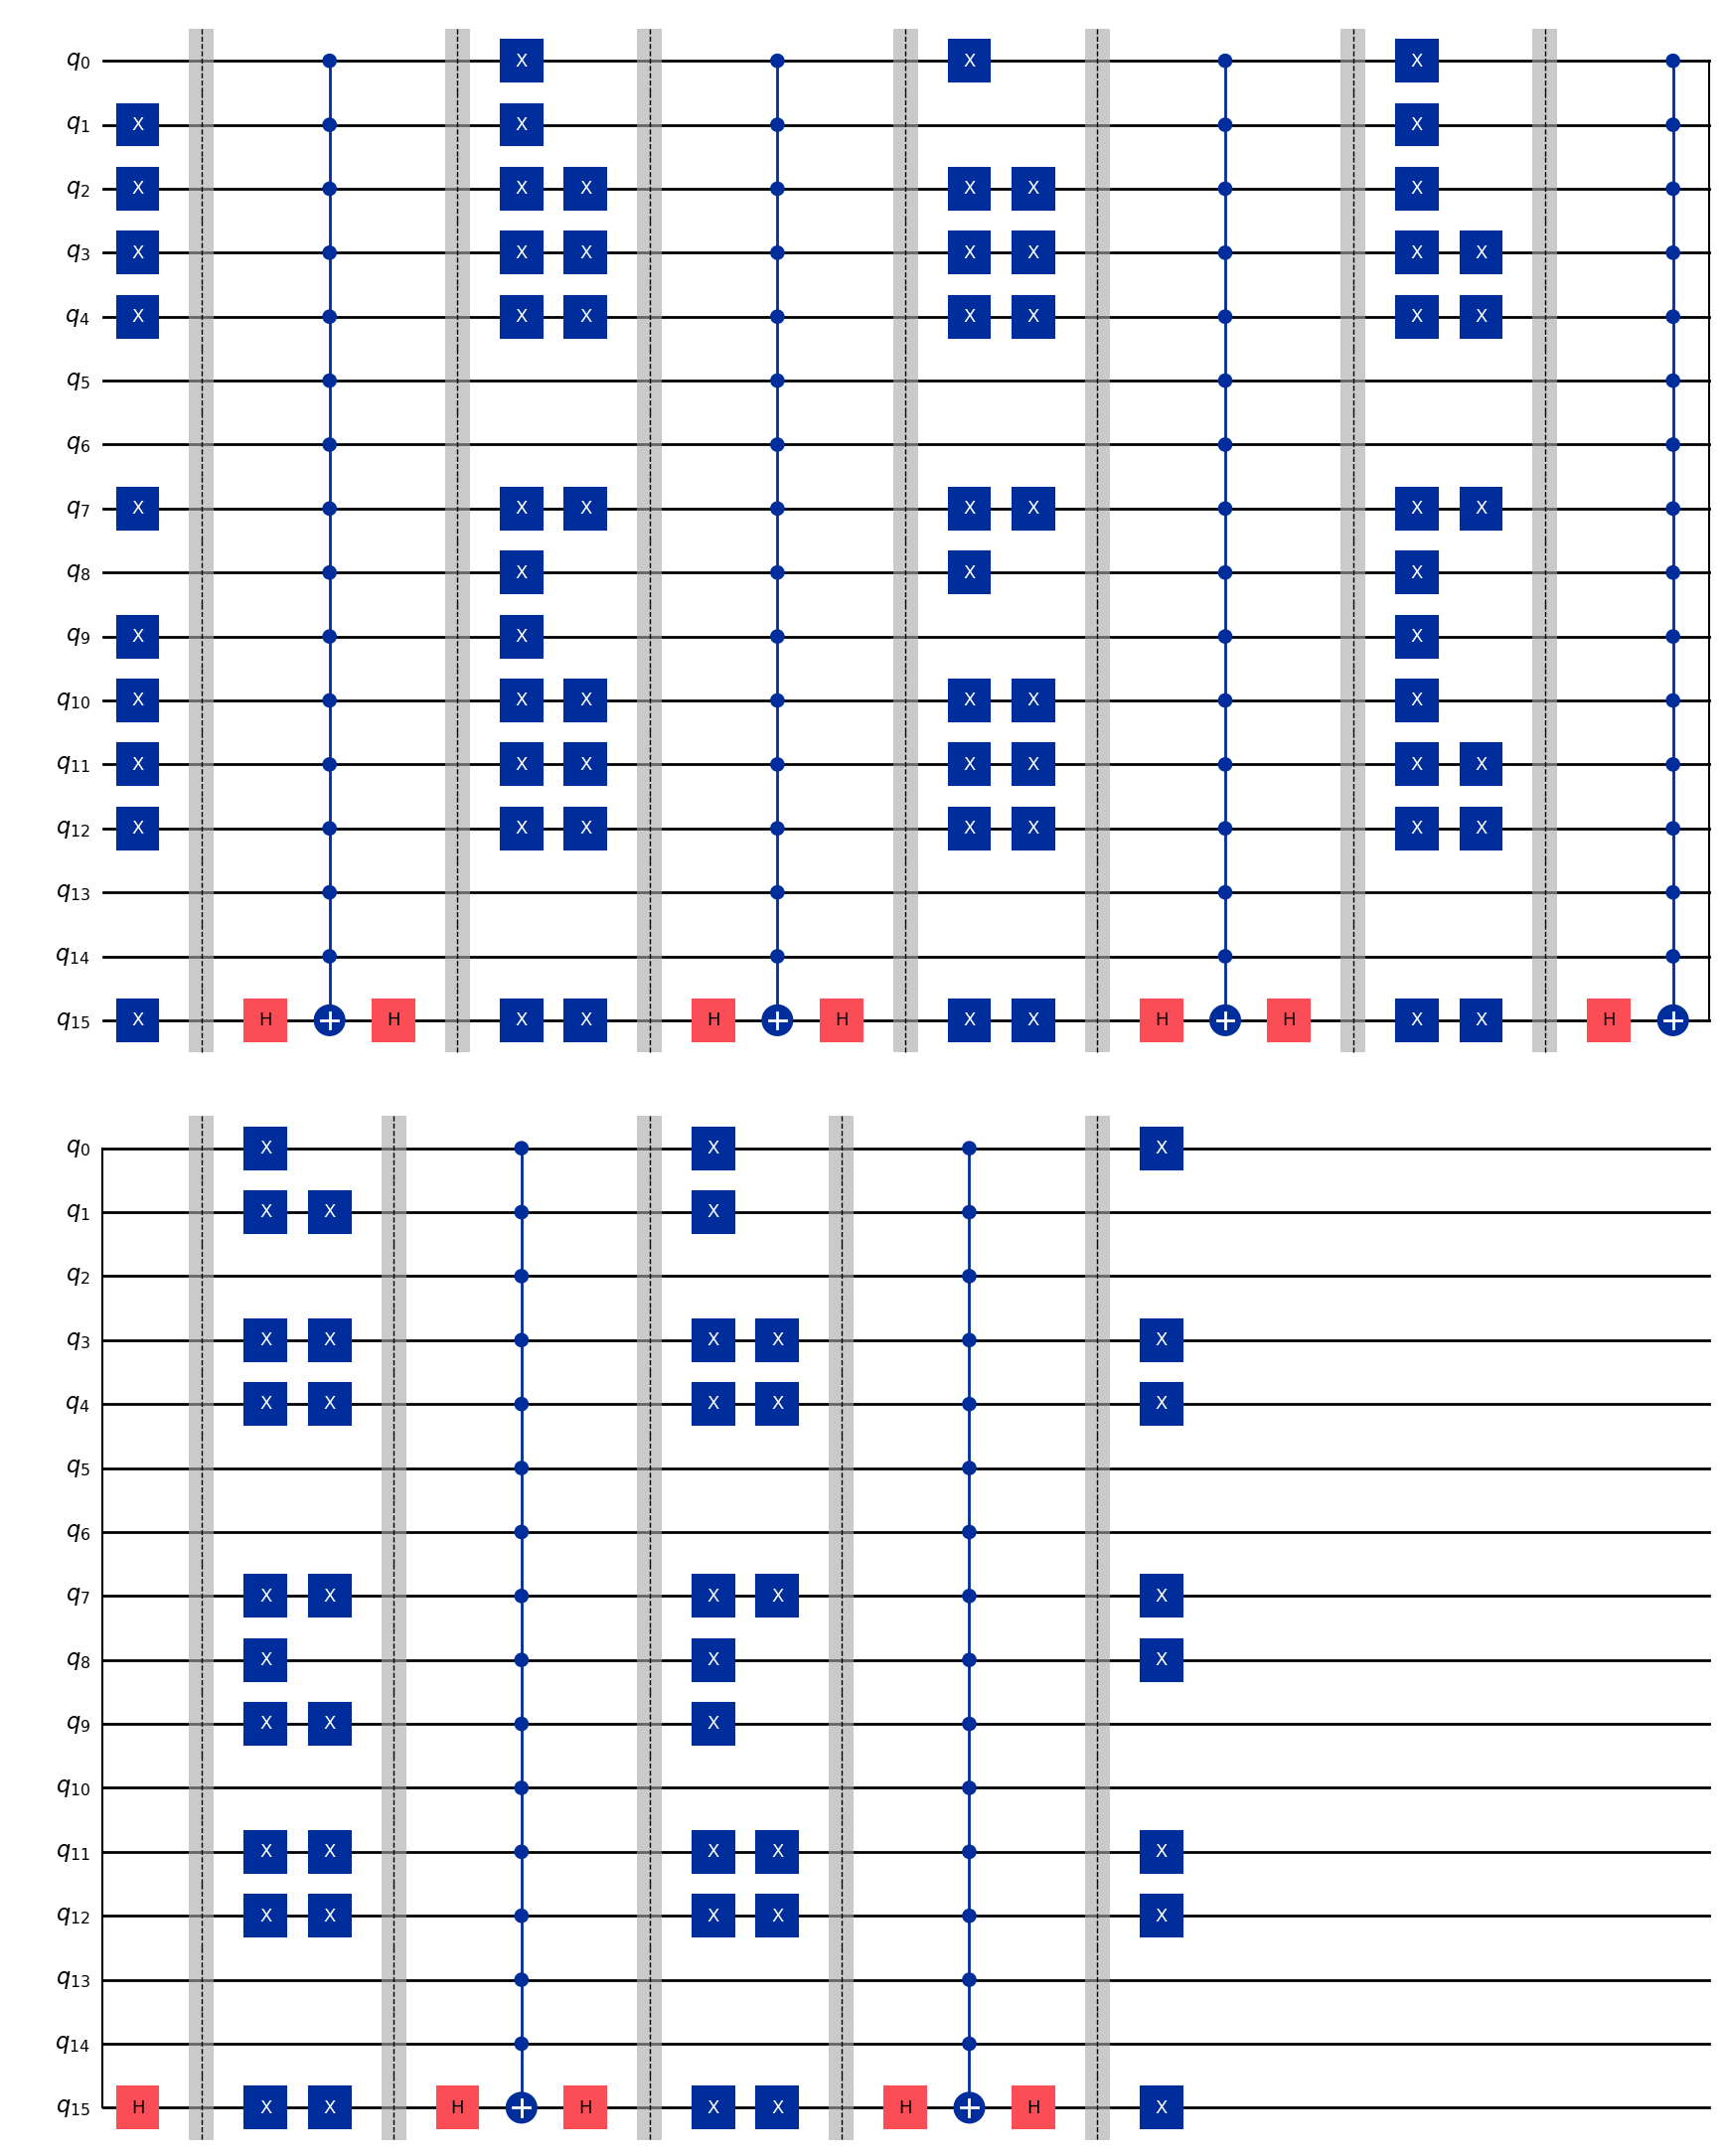

In [36]:
num_qubits = len(marked_states[0]) #if there are 3 bits so qc with 3 qubits and so on


oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

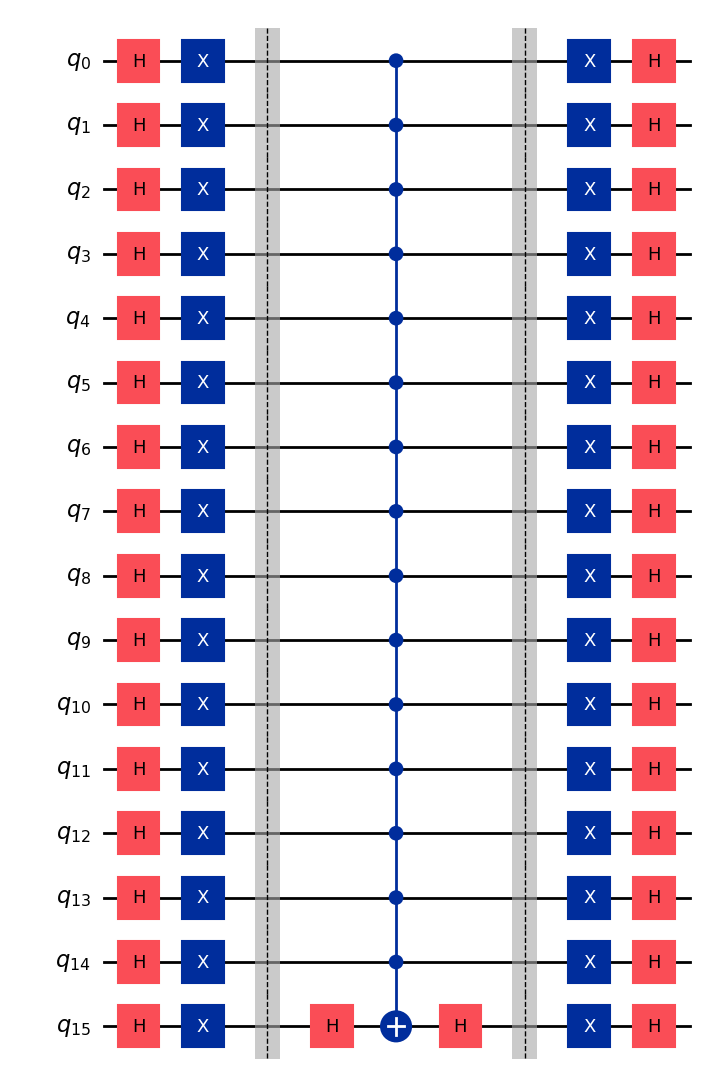

In [37]:
diffusion = diffusion_operator(num_qubits)
diffusion.draw(output="mpl", style="iqp")


**Grover's Algorithm**

1. Initialize an $n$-qubit register $Q$ to the all-zero state $|0_n\rangle$ and then apply a Hadamard operation to each qubit of $Q$.

2. Apply $t$ times the unitary operation
$$
G = (H \otimes n) Z_{\text{OR}} (H \otimes n) Z_f
$$ to the register $Q$.

3. Measure the qubits of $Q$ with respect to standard basis measurements and output the resulting string.

Here the $Z_f$ operation is depicted as being larger than $Z_{\text{OR}}$ as a way to suggest that it is likely to be the more costly operation (but this is only meant as a visual clue and not something with a formal meaning). In particular, when we're working within the query model, $Z_f$ requires one query while $Z_{\text{OR}}$ requires no queries — and if instead we have a Boolean circuit for the function $f$ and convert it to a quantum circuit for $Z_f$, we can reasonably expect that the resulting quantum circuit will be larger and more complicated than one for $Z_{\text{OR}}$.

Here's a description of a quantum circuit for the entire algorithm when $t = 2$. For larger values of $t$, we may simply insert additional instances of the Grover operation immediately before the measurements.

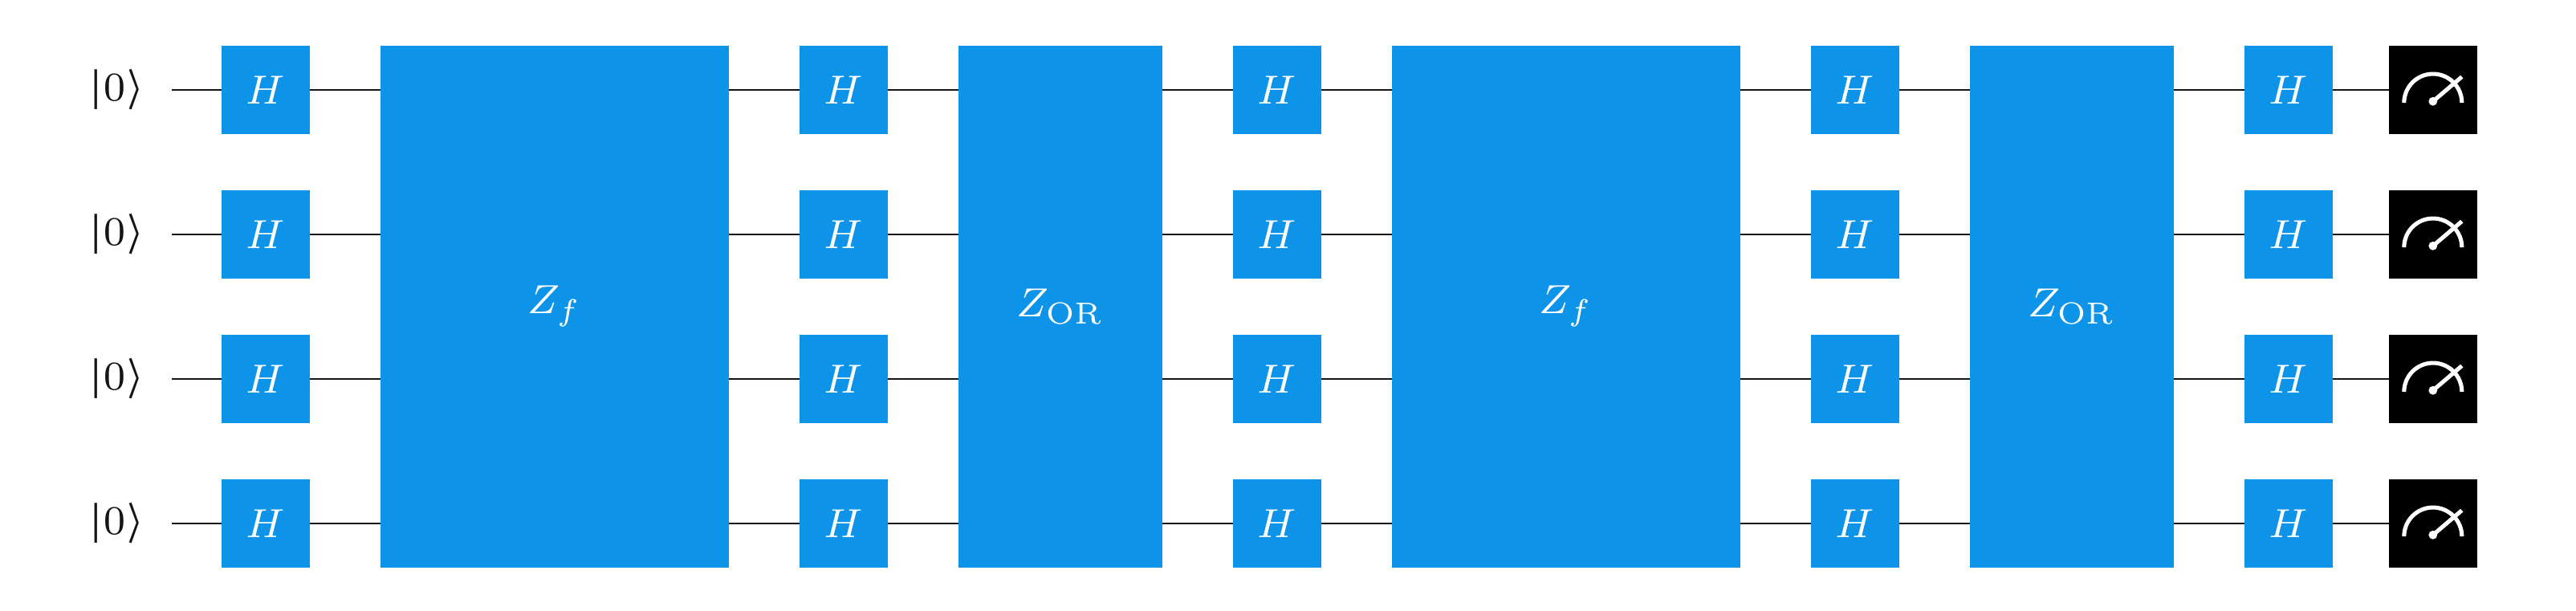

**Grover's Algorithm Applied to the Search Problem**

1. **Choose the number $t$**: In step 2 of the algorithm, choose the number $t$. The section following this one discusses how we can choose $t$.

2. **Run Grover's algorithm on the function $f$**: Apply Grover's algorithm to the function $f$, using the chosen value of $t$, to obtain a string $x \in \Sigma^n$.

3. **Query the function $f$ on the string $x$**: Check whether the string $x$ is a valid solution by querying the function $f(x)$:
   - If $f(x) = 1$, then we have found a solution, so we can stop and output the string $x$.
   - Otherwise, if $f(x) = 0$, then we can either:
     - Run the procedure again, possibly with a different choice for $t$, or
     - Decide to give up and output "no solution."


In [38]:
qc = QuantumCircuit(num_qubits)

# uniform superposition
qc.h(range(num_qubits))

num_iterations = floor(pi / (4 * asin(sqrt(len(marked_states) / 2**num_qubits))))

for _ in range(num_iterations): # running grover for the stipulated time
    qc.compose(oracle, inplace=True)
    qc.compose(diffusion, inplace=True)

qc.measure_all()
# qc.draw(output="mpl", style="iqp")

## Analysis
Now we'll analyze Grover's algorithm to understand how it works. We'll start with what could be described as a symbolic analysis, where we calculate how the Grover operation \( G \) acts on certain states, and then we'll tie this symbolic analysis to a geometric picture that's helpful for visualizing how the algorithm works.

### Solutions and Non-solutions
Let's start by defining two sets of strings.

$$
A_0 = \{ x \in \Sigma^n : f(x) = 0 \}
$$
$$
A_1 = \{ x \in \Sigma^n : f(x) = 1 \}
$$

The set \( A_1 \) contains all of the solutions to our search problem, and \( A_0 \) contains the strings that aren't solutions (which we can refer to as non-solutions when it's convenient). These two sets satisfy:

$$
A_0 \cap A_1 = \emptyset \quad \text{and} \quad A_0 \cup A_1 = \Sigma^n,
$$

which is to say that this is a bipartition of \( \Sigma^n \).

Next, we'll define two unit vectors representing uniform superpositions over the sets of solutions and non-solutions.

$$
|A_0 \rangle = \frac{1}{|A_0|} \sum_{x \in A_0} |x \rangle \quad |A_1 \rangle = \frac{1}{|A_1|} \sum_{x \in A_1} |x \rangle
$$

Formally speaking, each of these vectors is only defined when its corresponding set is nonempty, but hereafter we're going to focus on the case that neither \( A_0 \) nor \( A_1 \) is empty. The cases that \( A_0 = \emptyset \) and \( A_1 = \emptyset \) are easily handled separately, and we'll do that later.

As an aside, this notation is pretty common: any time we have a nonempty set \( S \), we can write \( |S \rangle \) to denote the quantum state vector that's uniform over the elements of \( S \).

Let us also define \( |u \rangle \) to be a uniform quantum state over all \( n \)-bit strings:

$$
|u \rangle = \frac{1}{N} \sum_{x \in \Sigma^n} |x \rangle
$$

Notice that

$$
|u \rangle = \frac{1}{N} |A_0 \rangle + \frac{1}{N} |A_1 \rangle
$$

We also have that

$$
|u \rangle = H^{\otimes n} |0^n \rangle,
$$

so \( |u \rangle \) represents the state of the register \( Q \) after the initialization in step 1 of Grover's algorithm. This implies that just before the iterations of \( G \) happen in step 2, the state of \( Q \) is contained in the two-dimensional vector space spanned by \( |A_0 \rangle \) and \( |A_1 \rangle \), and moreover, the coefficients of these vectors are real numbers.

As we will see, the state of \( Q \) will always have these properties — meaning that the state is a real linear combination of \( |A_0 \rangle \) and \( |A_1 \rangle \) — after any number of iterations of the operation \( G \) in step 2.

### An Observation About the Grover Operation
We'll now turn our attention to the Grover operation

$$
G = H^{\otimes n} Z_{OR} H^{\otimes n} Z_f,
$$

beginning with an interesting observation about it.

Imagine for a moment that we replaced the function \( f \) by the composition of \( f \) with the NOT function — or in other words, the function we get by flipping the output bit of \( f \). We'll call this new function \( g \), and we can express it using symbols in a few alternative ways.

$$
g(x) = \neg f(x) = 1 \oplus f(x) = 1 - f(x) = 
\begin{cases} 
1 & \text{if } f(x) = 0 \\ 
0 & \text{if } f(x) = 1 
\end{cases}
$$

Now, notice that

$$
Z_f = -Z_g.
$$

Recalling that \( Z_f |x \rangle = (-1)^{f(x)} |x \rangle \) for every string \( x \in \Sigma^n \), we can verify this by observing that

$$
(-1)^{g(x)} = (-1)^{1 \oplus f(x)} = -( -1)^{f(x)}.
$$

So, Grover's algorithm behaves in exactly the same way for \( g \) as it does for \( f \). Intuitively speaking, the algorithm doesn't really care which strings are solutions — it only needs to be able to distinguish solutions and non-solutions to operate as it does.

### Action of the Grover Operation
Now let's consider the action of \( G \) on the vectors \( |A_0 \rangle \) and \( |A_1 \rangle \).

First, let's observe that the operation \( Z_f \) has a very simple action on the vectors \( |A_0 \rangle \) and \( |A_1 \rangle \).

$$
Z_f |A_0 \rangle = |A_0 \rangle \quad Z_f |A_1 \rangle = -|A_1 \rangle
$$

Second, we have the operation \( H^{\otimes n} Z_{OR} H^{\otimes n} \). The operation \( Z_{OR} \) is defined as

$$
Z_{OR} |x \rangle = 
\begin{cases} 
|x \rangle & \text{if } x = 0^n \\ 
-|x \rangle & \text{if } x \neq 0^n 
\end{cases}
$$

again for every string \( x \in \Sigma^n \), and a convenient alternative way to express this operation is like this:

$$
Z_{OR} = 2 |0^n \rangle \langle 0^n| - I.
$$

(A simple way to verify that this expression agrees with the definition of \( Z_{OR} \) is to evaluate its action on standard basis states.) The operation \( H^{\otimes n} Z_{OR} H^{\otimes n} \) can therefore be written like this:

$$
H^{\otimes n} Z_{OR} H^{\otimes n} = 2 H^{\otimes n} |0^n \rangle \langle 0^n| H^{\otimes n} - I.
$$

Using the same notation \( |u \rangle \) that we used above for the uniform superposition over all \( n \)-bit strings, we can alternatively express \( H^{\otimes n} Z_{OR} H^{\otimes n} \) like this:

$$
H^{\otimes n} Z_{OR} H^{\otimes n} = 2 |u \rangle \langle u| - I.
$$

And now we have what we need to compute the action of \( G \) on \( |A_0 \rangle \) and \( |A_1 \rangle \). First, we compute the action of \( G \) on \( |A_0 \rangle \).

$$
G |A_0 \rangle = (2 |u \rangle \langle u| - I) Z_f |A_0 \rangle = (2 |u \rangle \langle u| - I) |A_0 \rangle = 2 \frac{|A_0|}{N} |u \rangle - |A_0 \rangle = 2 \frac{|A_0|}{N} \left( \frac{|A_0|}{N} |A_0 \rangle + \frac{|A_1|}{N} |A_1 \rangle \right) - |A_0 \rangle.
$$

$$
= - (1 - 2 \frac{|A_0|}{N}) |A_0 \rangle + 2 \frac{|A_0|}{N} \cdot \frac{|A_1|}{N} |A_1 \rangle = \frac{|A_0|}{N} - \frac{|A_1|}{N} |A_0 \rangle + 2 \frac{|A_0|}{N} \cdot \frac{|A_1|}{N} |A_1 \rangle.
$$

Second, the action of \( G \) on \( |A_1 \rangle \):

$$
G |A_1 \rangle = (2 |u \rangle \langle u| - I) Z_f |A_1 \rangle = - (2 |u \rangle \langle u| - I) |A_1 \rangle = - 2 \frac{|A_1|}{N} |u \rangle + |A_1 \rangle.
$$

From the expression of \( G |A_1 \rangle \):

$$
G |A_1 \rangle = - 2 \frac{|A_1|}{N} |u \rangle + |A_1 \rangle,
$$

we can substitute \( |u \rangle = \frac{|A_0|}{N} |A_0 \rangle + \frac{|A_1|}{N} |A_1 \rangle \) into the equation:

$$
G |A_1 \rangle = -2 \frac{|A_1|}{N} \left( \frac{|A_0|}{N} |A_0 \rangle + \frac{|A_1|}{N} |A_1 \rangle \right) + |A_1 \rangle.
$$

Expanding the terms, we get:

$$
G |A_1 \rangle = -2 \frac{|A_1|}{N} \cdot \frac{|A_0|}{N} |A_0 \rangle - 2 \left( \frac{|A_1|}{N} \right)^2 |A_1 \rangle + |A_1 \rangle.
$$

Combining like terms, the action of \( G \) on \( |A_1 \rangle \) becomes:

$$
G |A_1 \rangle = -2 \frac{|A_1|}{N} \cdot \frac{|A_0|}{N} |A_0 \rangle + \left( 1 - 2 \frac{|A_1|^2}{N^2} \right) |A_1 \rangle.
$$

### Summary of the Grover Operation's Action

In summary, the Grover operation \( G \) acts on \( |A_0 \rangle \) and \( |A_1 \rangle \) as follows:

For \( |A_0 \rangle \):

$$
G |A_0 \rangle = \left( 1 - 2 \frac{|A_0|^2}{N^2} \right) |A_0 \rangle + 2 \frac{|A_0|}{N} \cdot \frac{|A_1|}{N} |A_1 \rangle.
$$

For \( |A_1 \rangle \):

$$
G |A_1 \rangle = -2 \frac{|A_1|}{N} \cdot \frac{|A_0|}{N} |A_0 \rangle + \left( 1 - 2 \frac{|A_1|^2}{N^2} \right) |A_1 \rangle.
$$

# Analysis of the Two-Dimensional Subspace in Grover's Algorithm

As we already noted, the state of \( Q \) just prior to step 2 is contained in the two-dimensional space spanned by \( |A_0\rangle \) and \( |A_1\rangle \), and we have just established that \( G \) maps any vector in this space to another vector in the same space. This means that, for the sake of the analysis, we can focus our attention exclusively on this subspace.

To better understand what's happening within this two-dimensional space, let's express the action of \( G \) on this space as a matrix:

$$
M = 
\begin{pmatrix}
N|A_0| - |A_1| & -\frac{2 |A_1||A_0|}{N} \\
\frac{2 |A_0||A_1|}{N} & N|A_0| - |A_1|
\end{pmatrix},
$$

where the first and second rows/columns correspond to \( |A_0\rangle \) and \( |A_1\rangle \), respectively. So far in this series, we have always connected the rows and columns of matrices with the classical states of a system, but matrices can also be used to describe the actions of linear mappings on different bases, as we have here.

While it isn't at all obvious at first glance, the matrix \( M \) is what we obtain by squaring a simpler-looking matrix:

$$
\begin{pmatrix}
\frac{|A_0|}{N} & -\frac{|A_1|}{N} \\
\frac{|A_1|}{N} & \frac{|A_0|}{N}
\end{pmatrix}^2
=
\begin{pmatrix}
N|A_0| - |A_1| & -\frac{2 |A_1||A_0|}{N} \\
\frac{2 |A_0||A_1|}{N} & N|A_0| - |A_1|
\end{pmatrix}
= M.
$$

The matrix 

$$
\begin{pmatrix}
\frac{|A_0|}{N} & -\frac{|A_1|}{N} \\
\frac{|A_1|}{N} & \frac{|A_0|}{N}
\end{pmatrix}
$$

is a rotation matrix, which we can alternatively express as:

$$
\begin{pmatrix}
\frac{|A_0|}{N} & -\frac{|A_1|}{N} \\
\frac{|A_1|}{N} & \frac{|A_0|}{N}
\end{pmatrix}
=
\begin{pmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{pmatrix},
$$

for 

$$
\theta = \arcsin\left(\frac{|A_1|}{N}\right).
$$

This angle \( \theta \) is going to play a very important role in the analysis that follows, so it's worth stressing its importance here as we see it for the first time.

In light of this expression of the matrix, we observe that:

$$
M = 
\begin{pmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{pmatrix}^2
=
\begin{pmatrix}
\cos(2\theta) & -\sin(2\theta) \\
\sin(2\theta) & \cos(2\theta)
\end{pmatrix}.
$$

This is because rotating by the angle \( \theta \) two times is equivalent to rotating by the angle \( 2\theta \). Another way to see this is to make use of the alternative expression:

$$
\theta = \arccos\left(\frac{|A_0|}{N}\right),
$$

together with the double-angle formulas from trigonometry:

$$
\cos(2\theta) = \cos^2(\theta) - \sin^2(\theta),
$$

$$
\sin(2\theta) = 2\sin(\theta)\cos(\theta).
$$

## State Evolution in Grover's Algorithm

In summary, the state of the register \( Q \) at the start of step 2 is:

$$
|u\rangle = \frac{|A_0|}{N} |A_0\rangle + \frac{|A_1|}{N} |A_1\rangle = \cos(\theta) |A_0\rangle + \sin(\theta) |A_1\rangle,
$$

and the effect of applying \( G \) to this state is to rotate it by an angle \( 2\theta \) within the space spanned by \( |A_0\rangle \) and \( |A_1\rangle \).

For example:

$$
G|u\rangle = \cos(3\theta) |A_0\rangle + \sin(3\theta) |A_1\rangle,
$$

$$
G^2|u\rangle = \cos(5\theta) |A_0\rangle + \sin(5\theta) |A_1\rangle,
$$

$$
G^3|u\rangle = \cos(7\theta) |A_0\rangle + \sin(7\theta) |A_1\rangle.
$$

In general:

$$
G^t |u\rangle = \cos((2t+1)\theta) |A_0\rangle + \sin((2t+1)\theta) |A_1\rangle.
$$

# Choosing the Number of Iterations

As we have established in the previous section, the state vector of the register \( Q \) in Grover's algorithm remains in the two-dimensional subspace spanned by \( |A_0\rangle \) and \( |A_1\rangle \) once the initialization step has been performed. The goal is to find an element \( x \in A_1 \), and this goal will be accomplished if we can obtain the state \( |A_1\rangle \) — for if we measure this state, we're guaranteed to get a measurement outcome \( x \in A_1 \) (under the assumption that \( A_1 \) is nonempty, of course).

Given that the state of \( Q \) after \( t \) iterations in step 2 is

$$
G^t |u\rangle = \cos((2t+1)\theta) |A_0\rangle + \sin((2t+1)\theta) |A_1\rangle,
$$

this means that we should choose \( t \) so that

$$
\langle A_1 | G^t | u \rangle = \sin((2t+1)\theta)
$$

is as close to 1 as possible in absolute value, to maximize the probability of obtaining \( x \in A_1 \) from the measurement.

Notice that for any angle \( \theta \in (0, 2\pi) \), the value \( \sin((2t+1)\theta) \) oscillates as \( t \) increases, though it is not necessarily periodic — there's no guarantee that we'll ever get the same value twice.

We can plot the values we obtain for varying values of \( t \) as follows. First, we'll import the required libraries, then plot the value \( \sin((2t+1)\theta) \) for varying \( t \) and a fixed choice of \( \theta \) (which can be changed as desired).

Naturally, in addition to making the probability of obtaining an element \( x \in A_1 \) from the measurement large, we would also like to choose \( t \) to be as small as possible because \( t \) applications of the operation \( G \) require \( t \) queries to the function \( f \). Because we're aiming to make \( \sin((2t+1)\theta) \) close to 1 in absolute value, a natural way to do this is to choose \( t \) so that

$$
(2t+1)\theta \approx \frac{\pi}{2}.
$$

Solving for \( t \) yields

$$
t \approx \frac{\pi}{4\theta} - \frac{1}{2}.
$$

Of course, \( t \) must be an integer, so we won't necessarily be able to hit this value exactly — but what we can do is take the closest integer to this value, which is

$$
t = \left\lfloor \frac{\pi}{4\theta} \right\rfloor.
$$

As we proceed with the analysis, we'll see that the closeness of this integer to the target value naturally affects the performance of the algorithm.

(As an aside, if the target value \( \frac{\pi}{4\theta} - \frac{1}{2} \) happens to be exactly halfway between two integers, this expression of \( t \) is what we get by rounding up. We could alternatively round down, which makes sense to do because it means one fewer query — but this is secondary and unimportant for the sake of the lesson.)

Recalling that the value of the angle \( \theta \) is given by the formula

$$
\theta = \arcsin\left(\frac{|A_1|}{N}\right),
$$

we also see that our estimate \( t \approx \frac{\pi}{4\theta} - \frac{1}{2} \) depends on the number of strings in \( A_1 \). This presents a challenge if we don't know how many solutions we have, as we'll discuss later.

---

## Unique Search

First, let's focus on the situation in which there's a single string \( x \) such that \( f(x) = 1 \). Another way to say this is that we're considering an instance of the **Unique Search** problem.

In this case, we have

$$
\theta = \arcsin\left(\frac{1}{N}\right),
$$

which can conveniently be approximated as

$$
\theta = \arcsin\left(\frac{1}{N}\right) \approx \frac{1}{N}
$$

when \( N \) gets large. If we substitute \( \theta = \frac{1}{N} \) into the expression

$$
t = \left\lfloor \frac{\pi}{4\theta} \right\rfloor,
$$

we obtain

$$
t = \left\lfloor \frac{\pi}{4}N \right\rfloor.
$$

Recalling that \( t \) is not only the number of times the operation \( G \) is performed, but also the number of queries to the function \( f \) required by the algorithm, we see that we're on track to obtaining an algorithm that requires \( O(\sqrt{N}) \) queries.

---

Now we'll investigate how well this choice of \( t \) works. The probability that the final measurement results in the unique solution can be expressed explicitly as

$$
p(N, 1) = \sin^2\left((2t+1)\theta\right).
$$

The first argument, \( N \), refers to the number of possible solutions, and the second argument, which is \( 1 \) in this case, refers to the actual number of solutions. A bit later, we'll use the same notation more generally, where there are multiple solutions.
# Multiple Solutions

As the number of elements in \( A_1 \) varies, so too does the angle \( \theta \), which can have a significant effect on the algorithm's probability of success. For the sake of brevity, let's write \( s = |A_1| \) to denote the number of solutions, and as before, we'll assume that \( s \geq 1 \).

As a motivating example, let's imagine that we have \( s = 4 \) solutions rather than a single solution, as we considered above. This means that

$$
\theta = \sin^{-1}\left(\frac{4}{N}\right),
$$

which is approximately double the angle we had in the case where \( |A_1| = 1 \) when \( N \) is large.

Suppose that we didn't know any better, and selected the same value of \( t \) as in the unique solution setting:

$$
t = \left\lfloor \frac{\pi}{4} \sin^{-1}\left(\frac{1}{N}\right) \right\rfloor.
$$
# Unknown Number of Solutions

If the number of solutions \( s = |A_1| \) is unknown, then a different approach is required, for in this situation we have no knowledge of \( s \) to inform our choice of \( t \). There are different approaches.

One simple approach is to choose

$$
t \in \{1, \dots, \left\lfloor \frac{\pi N}{4} \right\rfloor \}
$$

uniformly at random.

As it turns out, selecting \( t \) in this way finds a solution (assuming one exists) with probability greater than 40%. This is not at all obvious, and requires an analysis that will not be included here. Intuitively speaking, it makes sense, particularly when we think about the geometric picture. The state of \( Q \) is being rotated a random number of times, which will likely give us a vector for which the coefficient of \( |A_1\rangle \) is reasonably large.

By repeating this procedure and checking the outcome in the same way as described before, the probability to find a solution can be made very close to 1.

There is a refined method that finds a solution when one exists using \( O(N/s) \) queries, even when the number of solutions \( s \) is not known. It requires \( O(N) \) queries to determine that there are no solutions when \( s = 0 \).

The basic idea is to choose \( t \) uniformly at random from the set \( \{1, \dots, T\} \) iteratively, for increasing values of \( T \). In particular, we can start with \( T = 1 \) and increase it exponentially, always terminating the process as soon as a solution is found and capping \( T \) so as not to waste queries when there isn't a solution. The process takes advantage of the fact that fewer queries are required when more solutions exist.

Some care is required, however, to balance the rate of growth of \( T \) with the probability of success for each iteration. Taking

$$
T \leftarrow \left\lceil \frac{5}{4} T \right\rceil
$$

works, as an analysis reveals. Doubling \( T \) does not — this turns out to be too fast of an increase.

## The Trivial Cases

Throughout the analysis we've just gone through, we've assumed that the number of solutions is non-zero. Indeed, by referring to the vectors

$$
|A_0\rangle = \frac{1}{|A_0|} \sum_{x \in A_0} |x\rangle \quad \text{and} \quad |A_1\rangle = \frac{1}{|A_1|} \sum_{x \in A_1} |x\rangle,
$$

we have implicitly assumed that \( A_0 \) and \( A_1 \) are both non-empty. Here we will briefly consider what happens when one of these sets is empty.

Before we bother with an analysis, let's observe the obvious: if every string \( x \in \Sigma_n \) is a solution, then we'll see a solution when we measure; and when there aren't any solutions, we won't get one. In some sense there's no need to go deeper than this.

We can, however, quickly verify the mathematics for these trivial cases. The situation where one of \( A_0 \) and \( A_1 \) is empty happens when \( f \) is constant; \( A_1 \) is empty when \( f(x) = 0 \) for every \( x \in \Sigma_n \), and \( A_0 \) is empty when \( f(x) = 1 \) for every \( x \in \Sigma_n \). This means that

$$
Z_f |u\rangle = \pm |u\rangle,
$$

and therefore

$$
G |u\rangle = (2|u\rangle \langle u| - I) Z_f |u\rangle = \pm (2|u\rangle \langle u| - I) |u\rangle = \pm |u\rangle.
$$

So, irrespective of the number of iterations \( t \) we perform in these cases, the measurements will always reveal a uniform random string \( x \in \Sigma_n \).


In [39]:
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=1)

# circuit_isa = pm.run(qc)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [40]:
# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 1024
# result = sampler.run([circuit_isa]).result()
# result = sampler.run([qc]).result()
# dist = result[0].data.meas.get_counts()

In [41]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session as Session

aer_sim = AerSimulator(method='statevector', device='CPU')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_circuit = pm.run(qc)
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([isa_circuit]).result()

**The Plot shows the Amplitude amplified search space**

{'0110011001100110': 182, '0110001101100011': 182, '0110010101100101': 170, '0110010001100100': 148, '0110000101100001': 165, '0110001001100010': 177}


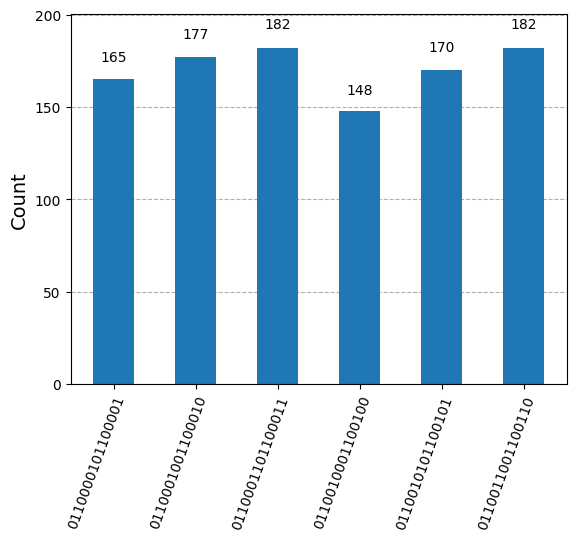

In [42]:
from qiskit.visualization import plot_histogram

outputs = result[0].data.meas
counts = outputs.get_counts()
# print(len(outputs.array))
print(counts)
display(plot_histogram(counts))

**Filling up the rest of the states with amplitude '0' apart from the ones that have amplified amplitude**

In [43]:
all_possible_states = [bin(x)[2:].zfill(num_qubits) for x in range(2**num_qubits)]
for state in all_possible_states:
    if state not in counts:
        counts[state] = 0

# display(plot_histogram(counts))

Identifying The "key" or the element/elements to be searched by searching among the states with amplified amplitude 

Identifying condition : Amplitude of the search space would be greater than the Average/median of the total Probability distribution

In [45]:
import numpy as np

check = input("Enter a list of strings separated by spaces to check: ").split()
print(check)
check_bin = encode(check)
# print(check_bin)

def decode(binary_strings):
  decoded_strings = []
  for binary_string in binary_strings:
    decoded_string = ""
    for i in range(0, len(binary_string), 8):
      byte = binary_string[i:i + 8]
      decoded_string += chr(int(byte, 2))
    decoded_strings.append(decoded_string)
  return decoded_strings

mean_prob = np.mean(list(counts.values()))
# stdev = np.std(list(counts.values()))
# print(mean_prob, stdev)
for bin_str in check_bin:
  # probability = get_state_probability(counts, bin_str)
  if (bin_str in counts) and  (counts[bin_str] >= mean_prob):
    print(decode([bin_str]), "is present in the initial search space")
  else:
    print(decode([bin_str]), "is not present in the initial search space")

['aa', 'bb', 'cat', 'dog', 'ab', 'bc']
['aa'] is present in the initial search space
['bb'] is present in the initial search space
['cat'] is not present in the initial search space
['dog'] is not present in the initial search space
['ab'] is not present in the initial search space
['bc'] is not present in the initial search space
